# EDA On Wifire BP3D Runs Dataset
Key Questions: 
- What existing features are useful in predicting the run time of a wifire simulation? 
- What features can be created to assist in eventually training a prediction model?
- What is the correlation between different variables and runtime?

# Setup

In [99]:
from tqdm import tqdm
import pandas as pd
import humanize
from pprint import pprint
from datetime import datetime, timedelta
import time
import seaborn as sns
import ast
from sklearn.preprocessing import MinMaxScaler

In [85]:
simulation_runs = pd.read_csv("simulation_runs.csv")
print(simulation_runs.columns)

Index(['Unnamed: 0', 'path', 'time_scraped', 'canopy_moisture', 'dz', 'extent',
       'extent_fmt', 'fire_grid', 'fuel', 'ignition', 'output', 'resolution',
       'resolution_units', 'run_binary', 'run_end', 'run_max_mem_rss_bytes',
       'run_start', 'seed', 'sim_time', 'surface_moisture', 'threads',
       'timestep', 'topo', 'wind_direction', 'wind_speed'],
      dtype='object')


In [86]:

def calculate_area(str):
    #where p1 in the bottom left = (x1,y1) and p2 in the bottom left = (x2,y2)
    L = ast.literal_eval(str)
    x1, y1, x2, y2 = float(L[0]), float(L[1]), float(L[2]), float(L[3])
    
    area = (x2-x1) * (y2-y1)
    return abs(area)
    
def convert(seconds):
    return humanize.naturaldelta(timedelta(seconds=seconds))


def get_run_time(run_start,run_end):
    start = datetime.fromisoformat(run_start)
    end = datetime.fromisoformat(run_end)
    return (end-start).seconds


# DataFrame Reshaping
add area column generated from `extent` and only extract relevant columns. Add all attrs from `output` as individual columns too

In [87]:
# look into topo
useful_columns = [
    "sim_time",
    "run_start",
    "run_end",
    "output",
    "extent",
    "surface_moisture",
    "timestep",
    "wind_direction",
    "wind_speed",
    "canopy_moisture",
    "resolution",
    "run_max_mem_rss_bytes",
    "seed"
]
run_data = simulation_runs.get(useful_columns)
column = run_data.apply(lambda row: calculate_area(row["extent"]), axis=1)
run_data = run_data.drop(columns=["extent"])
run_data = run_data.dropna(subset="output")

In [88]:

# add new columns

runtime = run_data.apply(
    lambda row: get_run_time(row["run_start"],row["run_end"]),
    axis=1
)

steps_fire = run_data.apply(
    lambda row: ast.literal_eval(row["output"])["steps_fire"],
    axis=1
)

# steps_wind = run_data.apply(
#     lambda row: ast.literal_eval(row["output"])["steps_wind"],
#     axis=1
# ) 
# everything was 100

run_data.insert(0,'runtime', runtime)
run_data = run_data.assign(area=column, steps_fire=steps_fire)
run_data = run_data.drop(columns=["run_start","run_end","output"])
# user friendly runtime like "6 hours"
# run_data["readrun"] = run_data.apply(
#     lambda row: convert(row["runtime"]),
#     axis=1
# )

run_data.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,resolution,run_max_mem_rss_bytes,seed,area,steps_fire
0,5475,4503,0.10,600,65.0,2.235,1.00,"[2.0, 2.0, 1.0]",1934680,-1,560976.0,600
1,9737,11382,0.05,600,90.0,4.470,0.90,"[2.0, 2.0, 1.0]",2470180,-1,1981888.0,600
2,501,3937,0.12,600,270.0,2.235,0.95,"[2.0, 2.0, 1.0]",517424,-1,359488.0,600
3,4325,4921,0.10,600,137.0,3.000,1.10,"[2.0, 2.0, 1.0]",2454040,-1,1053216.0,600
4,9008,14997,0.15,600,360.0,4.470,1.00,"[2.0, 2.0, 1.0]",3919432,-1,648024.0,600


In [89]:
print(run_data.shape)
duplicate_rows_df = run_data[run_data.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)
run_data = run_data.drop_duplicates()

run_data.head()

(1801, 12)
number of duplicate rows:  (234, 12)


,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,resolution,run_max_mem_rss_bytes,seed,area,steps_fire
0,5475,4503,0.10,600,65.0,2.235,1.00,"[2.0, 2.0, 1.0]",1934680,-1,560976.0,600
1,9737,11382,0.05,600,90.0,4.470,0.90,"[2.0, 2.0, 1.0]",2470180,-1,1981888.0,600
2,501,3937,0.12,600,270.0,2.235,0.95,"[2.0, 2.0, 1.0]",517424,-1,359488.0,600
3,4325,4921,0.10,600,137.0,3.000,1.10,"[2.0, 2.0, 1.0]",2454040,-1,1053216.0,600
4,9008,14997,0.15,600,360.0,4.470,1.00,"[2.0, 2.0, 1.0]",3919432,-1,648024.0,600


In [90]:
# new_df = run_data.get("path")

# # steps_fire = run_data.apply(
# #     lambda row: ast.literal_eval(row["output"])["steps_fire"],
# #     axis=1
# # )
# id = new_df.apply(
#     lambda row: row.split("run_")[1], 
# )
# df = pd.DataFrame(data={"run_id":id})
# df.to_csv("run_id.csv")

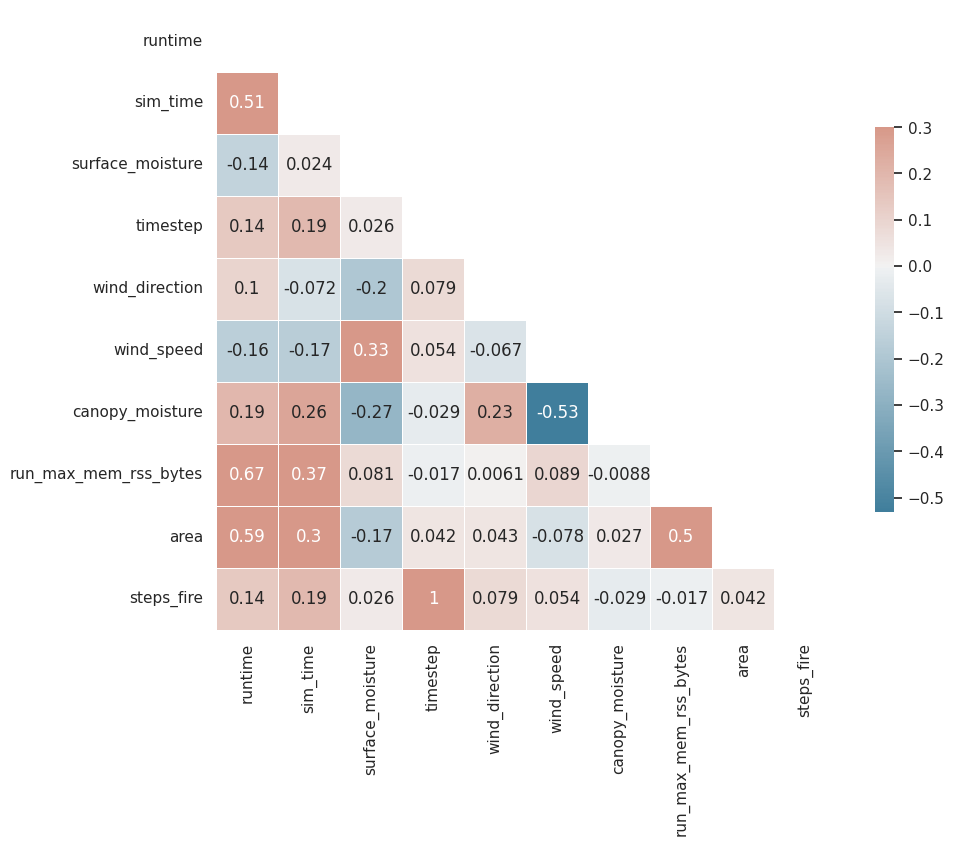

In [91]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

run_data = run_data.drop(columns=["resolution","seed"])

# Compute the correlation matrix
corr = run_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            annot=True,square=True, linewidths=.5, cbar_kws={"shrink": .5})

fig = f.get_figure()
fig.savefig("correlation.png") 

In [92]:
# plt.figure(figsize=(15,10))
# sns.pairplot(run_data,hue="runtime")
# plt.title("Looking for Insights in Data")
# plt.legend("HeartDisease")
# plt.tight_layout()
# plt.plot()

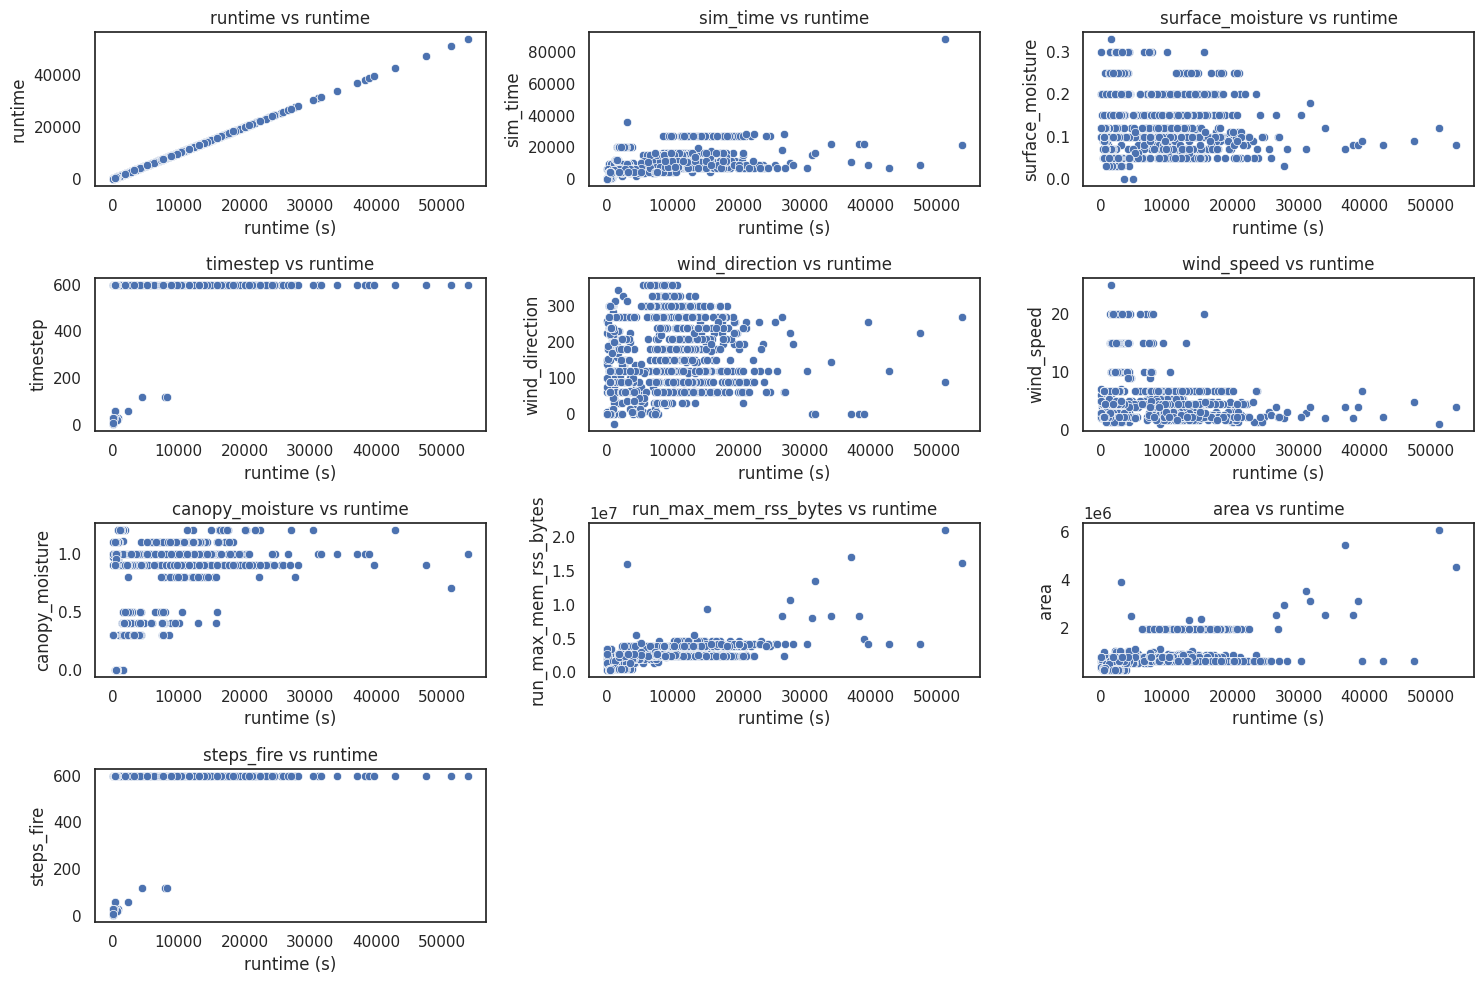

In [93]:
# run_data = run_data.drop(columns=["readrun"])
plt.figure(figsize=(15,10))
for i,col in enumerate(run_data.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"{col} vs runtime")
    plt.xlabel("runtime (s)")
    sns.scatterplot(data=run_data, x="runtime", y=col)
    plt.tight_layout()
    plt.plot()
plt.savefig("runtimecorrelationplots.jpg")

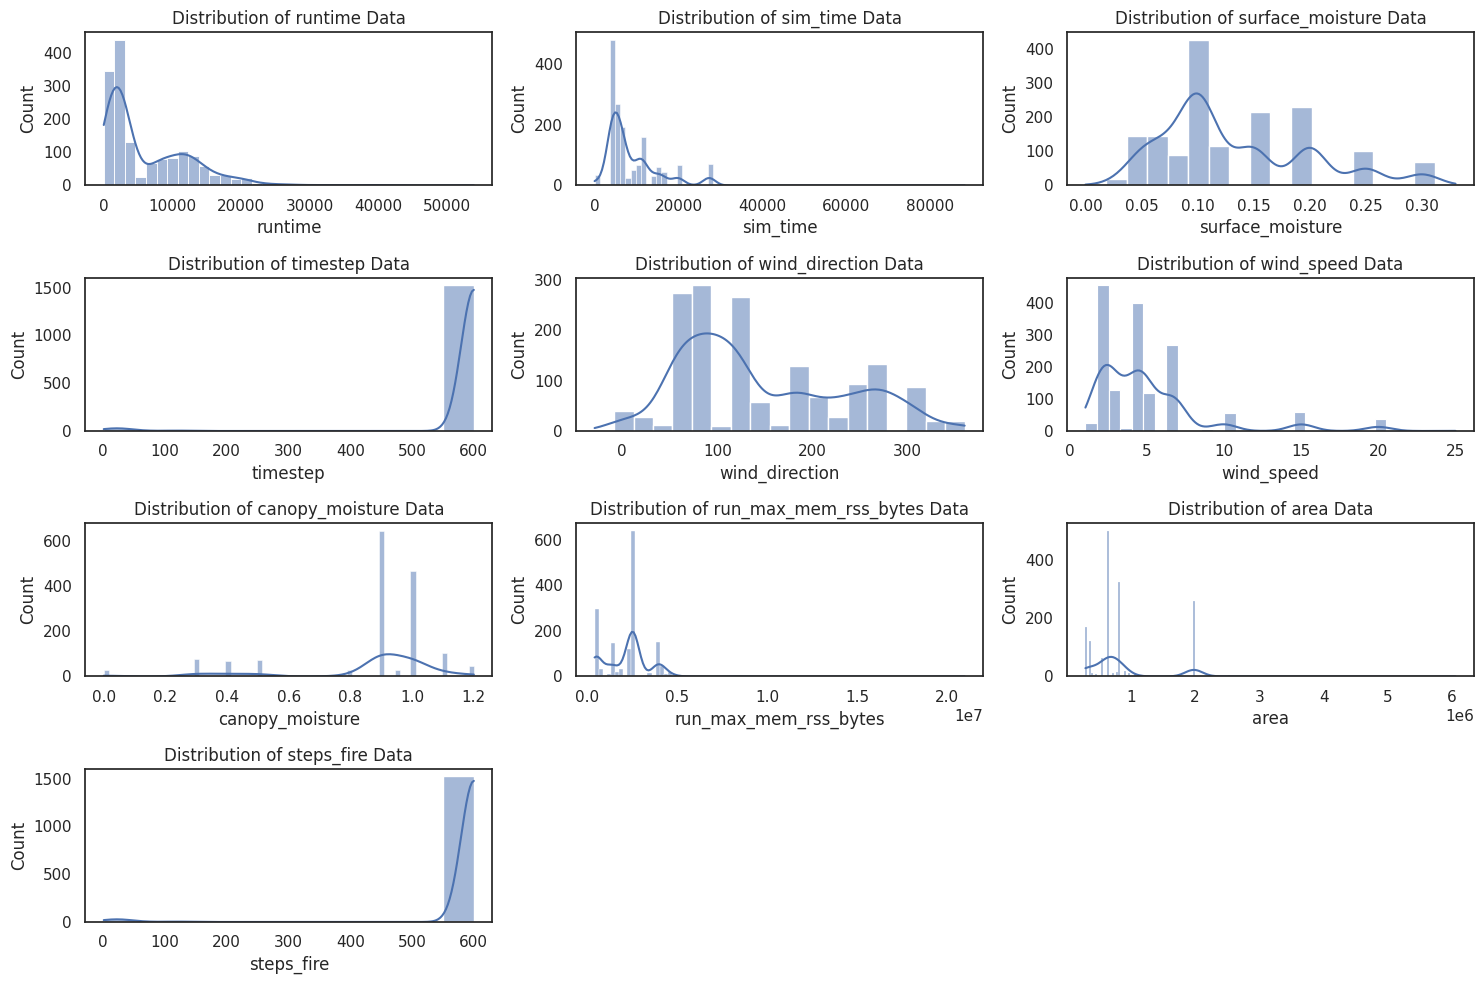

In [94]:
plt.figure(figsize=(15,10))
for i,col in enumerate(run_data.columns,1):
    plt.subplot(4,3,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(run_data[col],kde=True)
    plt.tight_layout()
    plt.plot()

plt.savefig("dist.png")

In [95]:
# sns.pairplot(run_data)

In [96]:
print(len(run_data))
run_data.isnull().sum()

1567


runtime                  0
sim_time                 0
surface_moisture         0
timestep                 0
wind_direction           0
wind_speed               0
canopy_moisture          0
run_max_mem_rss_bytes    0
area                     0
steps_fire               0
dtype: int64

# Normalize

In [97]:
def normalize(series):
    return MinMaxScaler().fit_transform(np.array(series).reshape(-1,1))

In [98]:
y = pd.DataFrame(run_data['runtime'], columns=['runtime'])

for column in run_data.columns:
    if column != "runtime":
        run_data[column] = normalize(run_data[column])

X = run_data.drop(columns=["runtime"])
run_data.head()

,runtime,sim_time,surface_moisture,timestep,wind_direction,wind_speed,canopy_moisture,run_max_mem_rss_bytes,area,steps_fire
0,5475,0.050966,0.303030,1.0,0.241645,0.051458,0.833333,0.074582,0.046235,1.0
1,9737,0.128999,0.151515,1.0,0.305913,0.144583,0.750000,0.100625,0.293084,1.0
2,501,0.044546,0.363636,1.0,0.768638,0.051458,0.791667,0.005656,0.011231,1.0
3,4325,0.055708,0.303030,1.0,0.426735,0.083333,0.916667,0.099840,0.131749,1.0
4,9008,0.170005,0.454545,1.0,1.000000,0.144583,0.833333,0.171107,0.061357,1.0
